# Create DummyGPTModel

In [ ]:
GPT_CONFIG_124M = {
    'vocab_size': 50257,
    'ctx_len': 1024,
    'emb_dim': 768,
    'n_heads': 12,
    'n_layers': 12,
    'drop_rate': 0.1,
    'drop_rate_emb': 0.1,
    'drop_rate_ffn': 0.1,
    'drop_rate_attn': 0.1,
    'drop_rate_resid': 0.1,
    'qkv_bias': False
}

In [ ]:
import torch
import torch.nn as nn

class DummyGPTModel(nn.Module):
  def __init__(self, cfg):
    super().__init__()
    self.tok_emb = nn.Embedding(cfg['vocab_size'], cfg['emb_dim'])
    self.pos_emb = nn.Embedding(cfg['ctx_len'], cfg['emb_dim'])
    self.drop_emb = nn.Dropout(cfg['drop_rate'])
    self.trf_blocks = nn.Sequential(
        *[DummyTransformerBlock(cfg) for _ in range(cfg['n_layers'])]
    )
    self.final_norm = DummyLayerNorm(cfg['emb_dim'])
    self.out_head = nn.Linear(
        cfg['emb_dim'], cfg['vocab_size'], bias=False
    )

  def forward(self, in_idx):
    batch_size, seq_len = in_idx.shape
    tok_embeds = self.tok_emb(in_idx)
    pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
    x = tok_embeds + pos_embeds
    x = self.drop_emb(x)
    x = self.trf_blocks(x)
    x = self.final_norm(x)
    logits = self.out_head(x)
    return logits

class DummyTransformerBlock(nn.Module):
  def __init__(self, cfg):
    super().__init__()

  def forward(self, x):
    return x

class DummyLayerNorm(nn.Module):
  def __init__(self, normalized_shape, eps=1e-5):
    super().__init__()

  def forward(self, x):
    return x

# Tokenizer + GPT-2 init

In [ ]:
import tiktoken

tokenizer = tiktoken.get_encoding('gpt2')
batch = []
txt1 = 'Every effort moves you'
txt2 = 'Every day holds a'

batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch, dim=0)

print(batch)

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


In [ ]:
torch.manual_seed(123)
model = DummyGPTModel(GPT_CONFIG_124M)
logits = model(batch)
print(f'{logits.shape=}')
print(logits)

logits.shape=torch.Size([2, 4, 50257])
tensor([[[-0.9289,  0.2748, -0.7557,  ..., -1.6070,  0.2702, -0.5888],
         [-0.4476,  0.1726,  0.5354,  ..., -0.3932,  1.5285,  0.8557],
         [ 0.5680,  1.6053, -0.2155,  ...,  1.1624,  0.1380,  0.7425],
         [ 0.0447,  2.4787, -0.8843,  ...,  1.3219, -0.0864, -0.5856]],

        [[-1.5474, -0.0542, -1.0571,  ..., -1.8061, -0.4494, -0.6747],
         [-0.8422,  0.8243, -0.1098,  ..., -0.1434,  0.2079,  1.2046],
         [ 0.1355,  1.1858, -0.1453,  ...,  0.0869, -0.1590,  0.1552],
         [ 0.1666, -0.8138,  0.2307,  ...,  2.5035, -0.3055, -0.3083]]],
       grad_fn=<UnsafeViewBackward0>)


# Layer norm

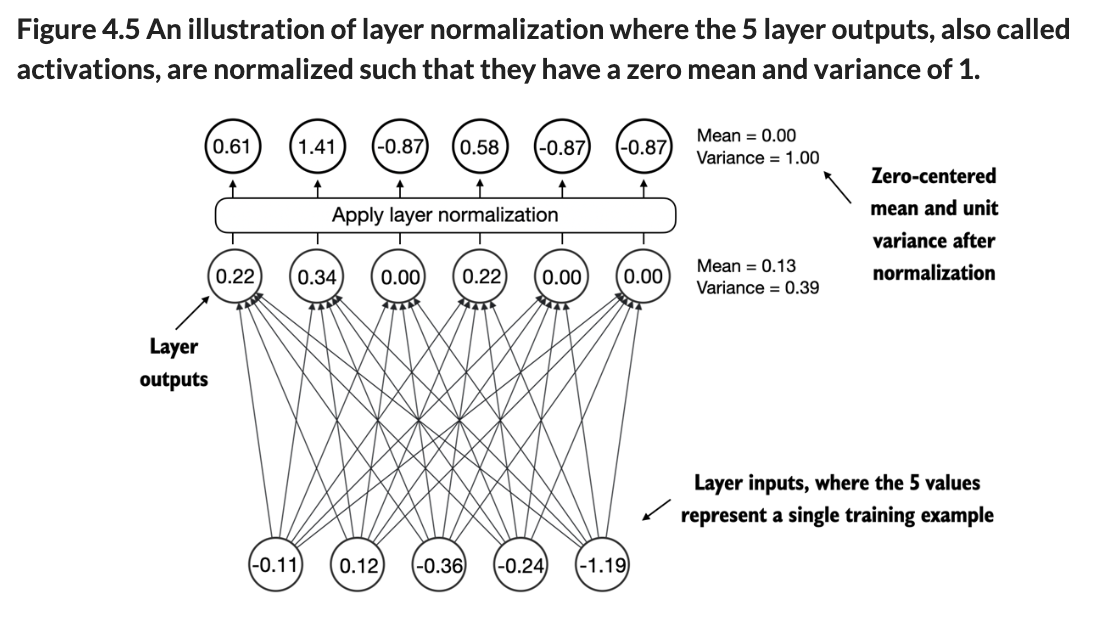

In [ ]:
torch.manual_seed(123)
batch_example = torch.randn(2, 5)
layer = nn.Sequential(nn.Linear(5, 6), nn.ReLU())
out = layer(batch_example)
print(f'{out.shape=}\n{out}')

out.shape=torch.Size([2, 6])
tensor([[0.2260, 0.3470, 0.0000, 0.2216, 0.0000, 0.0000],
        [0.2133, 0.2394, 0.0000, 0.5198, 0.3297, 0.0000]],
       grad_fn=<ReluBackward0>)


In [ ]:
# mean and var before layer norm
mean = out.mean(dim=-1, keepdim=True)
var = out.var(dim=-1, keepdim=True)
print(f'{mean=}\n{var=}')

mean=tensor([[0.1324],
        [0.2170]], grad_fn=<MeanBackward1>)
var=tensor([[0.0231],
        [0.0398]], grad_fn=<VarBackward0>)


In [ ]:
# apply layer norm
out_norm = (out-mean) / torch.sqrt(var)
mean = out_norm.mean(dim=-1, keepdim=True)
var = out_norm.var(dim=-1, keepdim=True)
print(f'{out_norm=}\n{mean=}\n{var=}')

out_norm=tensor([[ 0.6159,  1.4126, -0.8719,  0.5872, -0.8719, -0.8719],
        [-0.0189,  0.1121, -1.0876,  1.5173,  0.5647, -1.0876]],
       grad_fn=<DivBackward0>)
mean=tensor([[9.9341e-09],
        [1.9868e-08]], grad_fn=<MeanBackward1>)
var=tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


In [ ]:
# create a proper class
class LayerNorm(nn.Module):
  def __init__(self, emb_dim):
    super().__init__()
    self.eps = 1e-5
    self.scale = nn.Parameter(torch.ones(emb_dim))
    self.shift = nn.Parameter(torch.zeros(emb_dim))

  def forward(self, x):
    mean = x.mean(dim=-1, keepdim=True)
    var = x.var(dim=-1, keepdim=True, unbiased=False)
    # unbiased=False -> divide by n, not n-1 (Bassel's correction)
    norm_x = (x-mean) / torch.sqrt(var + self.eps)
    return self.scale * norm_x + self.shift

In [ ]:
ln = LayerNorm(emb_dim=5)
out_ln = ln(batch_example)
mean = out_ln.mean(dim=-1, keepdim=True)
var = out_ln.var(dim=-1, unbiased=False, keepdim=True)
print(f'{mean=}\n{var=}')

mean=tensor([[-2.9802e-08],
        [ 0.0000e+00]], grad_fn=<MeanBackward1>)
var=tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


# Activation functions in LLMs

In [ ]:
class GELU(nn.Module):
  def __init__(self):
    super().__init__()

  def forward(self, x):
    return 0.5 * x * (1+torch.tanh(
        torch.sqrt(torch.tensor(2.0/torch.pi)) *
        (x + 0.044715 * torch.pow(x, 3))
    ))

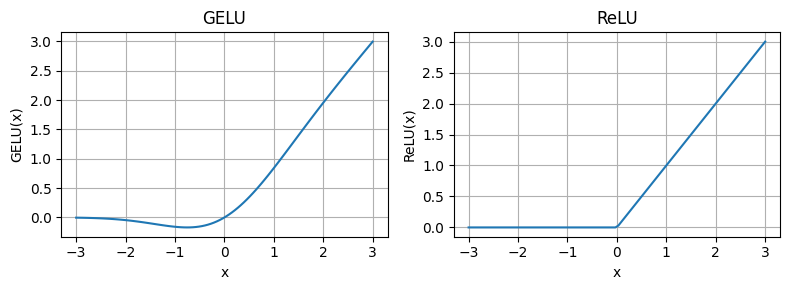

In [ ]:
# ReLU vs GELU
import matplotlib.pyplot as plt
gelu, relu = GELU(), nn.ReLU()

x = torch.linspace(-3, 3, 100)
y_gelu, y_relu = gelu(x), relu(x)
plt.figure(figsize=(8, 3))
for i, (y, label) in enumerate(zip([y_gelu, y_relu], ['GELU', 'ReLU']), 1):
  plt.subplot(1,2,i)
  plt.plot(x, y)
  plt.title(label)
  plt.xlabel('x')
  plt.ylabel(f'{label}(x)')
  plt.grid(True)
plt.tight_layout()
plt.show()

# FeedForward NN

In [ ]:
class FeedForward(nn.Module):
  def __init__(self, cfg):
    super().__init__()
    self.layers = nn.Sequential(
        nn.Linear(cfg['emb_dim'], 4 * cfg['emb_dim']),
        GELU(),
        nn.Linear(4 * cfg['emb_dim'], cfg['emb_dim']),
        nn.Dropout(cfg['drop_rate_ffn'])
    )

  def forward(self, x):
    return self.layers(x)

In [ ]:
ffn = FeedForward(GPT_CONFIG_124M)
x = torch.rand(2,3,768)
out = ffn(x)
print(out.shape)

torch.Size([2, 3, 768])


# Residual connections


In [ ]:
class ExampleDeepNeuralNetwork(nn.Module):
  def __init__(self, layer_sizes, use_shortcut):
    super().__init__()
    self.use_shortcut = use_shortcut
    self.layers = nn.ModuleList([
        nn.Sequential(nn.Linear(layer_sizes[0], layer_sizes[1]), GELU()),
        nn.Sequential(nn.Linear(layer_sizes[1], layer_sizes[2]), GELU()),
        nn.Sequential(nn.Linear(layer_sizes[2], layer_sizes[3]), GELU()),
        nn.Sequential(nn.Linear(layer_sizes[3], layer_sizes[4]), GELU()),
        nn.Sequential(nn.Linear(layer_sizes[4], layer_sizes[5]), GELU())
    ])

  def forward(self, x):
    for layer in self.layers:
      # current layer output
      layer_output = layer(x)
      # check if shortcut can be applied
      if self.use_shortcut and x.size() == layer_output.size():
        x = x + layer_output
      else:
        x = layer_output
    return x

In [ ]:
layer_sizes = [3, 3, 3, 3, 3, 1]
sample_input = torch.tensor([[1., 0., -1.]])
model_without_shortcut = ExampleDeepNeuralNetwork(
    layer_sizes, use_shortcut=False
)

In [ ]:
def print_gradients(model, x):
  output = model(x)
  target = torch.tensor([[0.]])

  loss = nn.MSELoss()
  loss = loss(output, target)

  loss.backward()

  for name, param in model.named_parameters():
        if 'weight' in name:
            # mean absolute gradient of weights
            print(f"{name} has gradient mean of {param.grad.abs().mean().item()}")

In [ ]:
print_gradients(model_without_shortcut, sample_input)
# vanishing gradients

layers.0.0.weight has gradient mean of 0.005461410153657198
layers.1.0.weight has gradient mean of 0.0038280922453850508
layers.2.0.weight has gradient mean of 0.01239895448088646
layers.3.0.weight has gradient mean of 0.008147694170475006
layers.4.0.weight has gradient mean of 0.07137995213270187


In [ ]:
# model with residual connections
torch.manual_seed(123)
model_with_shortcut = ExampleDeepNeuralNetwork(layer_sizes, use_shortcut=True)
print_gradients(model_with_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.22169798612594604
layers.1.0.weight has gradient mean of 0.20694111287593842
layers.2.0.weight has gradient mean of 0.3289700150489807
layers.3.0.weight has gradient mean of 0.26657330989837646
layers.4.0.weight has gradient mean of 1.3258544206619263


# Transformer block

In [ ]:
# pip install import-ipynb
import import_ipynb
from Chapter_3_self_attention import MultiHeadAttention

class TransformerBlock(nn.Module):
  def __init__(self, cfg):
    super().__init__()
    self.att = MultiHeadAttention(
        d_in=cfg['emb_dim'],
        d_out=cfg['emb_dim'],
        block_size=cfg['ctx_len'],
        num_heads=cfg['n_heads'],
        dropout=cfg['drop_rate_attn'],
        qkv_bias=cfg['qkv_bias']
    )
    self.ff = FeedForward(cfg)
    self.norm1 = LayerNorm(cfg['emb_dim'])
    self.norm2 = LayerNorm(cfg['emb_dim'])
    self.drop_resid = nn.Dropout(cfg['drop_rate_resid'])

  def forward(self, x):
    # apply norm before the self-attn and ff
    # known as pre-LayerNorm, opposite is post-LayerNorm
    shortcut = x
    x = self.norm1(x)
    x = self.att(x)
    x = self.drop_resid(x)
    x = x + shortcut

    shortcut = x
    x = self.norm2(x)
    x = self.ff(x)
    x = self.drop_resid(x)
    x = x + shortcut
    return x

importing Jupyter notebook from Chapter_3_self_attention.ipynb
tensor([0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865])
attention weights:  tensor([0.1455, 0.2278, 0.2249, 0.1285, 0.1077, 0.1656])
sum:  tensor(1.0000)
attention weights:  tensor([0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581])
sum:  tensor(1.)
attention weights: tensor([0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581])
sum: tensor(1.)
tensor([0.4419, 0.6515, 0.5683])
tensor([[0.9995, 0.9544, 0.9422, 0.4753, 0.4576, 0.6310],
        [0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865],
        [0.9422, 1.4754, 1.4570, 0.8296, 0.7154, 1.0605],
        [0.4753, 0.8434, 0.8296, 0.4937, 0.3474, 0.6565],
        [0.4576, 0.7070, 0.7154, 0.3474, 0.6654, 0.2935],
        [0.6310, 1.0865, 1.0605, 0.6565, 0.2935, 0.9450]])
tensor([[0.9995, 0.9544, 0.9422, 0.4753, 0.4576, 0.6310],
        [0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865],
        [0.9422, 1.4754, 1.4570, 0.8296, 0.7154, 1.0605],
        [0.4753, 0.8434, 0.8296, 0.4937,

In [ ]:
torch.manual_seed(123)
x = torch.rand(2,4,768)
block = TransformerBlock(GPT_CONFIG_124M)
output = block(x)
print(f'input shape: {x.shape}\noutput shape: {output.shape}')
# the transformer block maintains the input dim

input shape: torch.Size([2, 4, 768])
output shape: torch.Size([2, 4, 768])


# Coding the GPT model

In [ ]:
class GPTModel(nn.Module):
  def __init__(self, cfg):
    super().__init__()
    self.tok_emb = nn.Embedding(cfg['vocab_size'], cfg['emb_dim'])
    self.pos_emb = nn.Embedding(cfg['ctx_len'], cfg['emb_dim'])
    self.drop_emb = nn.Dropout(cfg['drop_rate_emb'])
    self.trf_blocks = nn.Sequential(
        *[TransformerBlock(cfg) for _ in range(cfg['n_layers'])]
    )
    self.final_norm = LayerNorm(cfg['emb_dim'])
    self.out_head = nn.Linear(cfg['emb_dim'], cfg['vocab_size'], bias=False)

  def forward(self, in_idx):
    batch_size, seq_len = in_idx.shape
    tok_embeds = self.tok_emb(in_idx)
    pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
    x = tok_embeds + pos_embeds
    x = self.trf_blocks(x)
    x = self.final_norm(x)
    logits = self.out_head(x)
    return logits

In [ ]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
out = model(batch)
print(f'{batch=}\n{out.shape=}\n{out=}')

batch=tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])
out.shape=torch.Size([2, 4, 50257])
out=tensor([[[-0.3836,  0.1907, -0.2999,  ...,  0.0701, -0.3504, -0.8911],
         [ 0.3457, -0.4659, -0.7705,  ..., -0.3331,  0.0161,  0.1663],
         [ 0.9492, -0.1808, -0.0225,  ...,  0.2096, -0.3042, -0.1051],
         [-0.8163,  0.3850, -0.2297,  ...,  1.0137,  0.4000, -0.4916]],

        [[ 0.0851,  0.1240, -0.0751,  ...,  0.5713,  0.2818, -0.6030],
         [ 0.0400, -0.2573,  0.0609,  ...,  0.5641, -0.1687,  0.3409],
         [ 0.9161,  1.0140, -0.2341,  ...,  0.2165,  0.5243,  0.1291],
         [ 0.1589,  0.2120,  0.6350,  ...,  0.9529, -0.1897, -0.3581]]],
       grad_fn=<UnsafeViewBackward0>)


In [ ]:
total_params = sum(p.numel() for p in model.parameters())
print(f"# of params: {total_params:,}")

# of params: 163,009,536


### This GPT-2 model was supposed to be 124M params. Why 163M ?

Because of 'weight tying' that is used in the original GPT-2 architecture - the model is reusing the token embedding layer as its output layer (the output layer's params are included in the 163M). Weight tying reduces the overall memory footprint and computational complexity. But according to the book modern LLMs use separate (use them both)



In [ ]:
print("token embedding layer:", model.tok_emb.weight.shape)
print("output layer:", model.out_head.weight.shape)

token embedding layer: torch.Size([50257, 768])
output layer: torch.Size([50257, 768])


In [ ]:
total_params_gpt2 =  total_params - sum(p.numel() for p in model.out_head.parameters())
print(f"# params with weight tying: {total_params_gpt2:,}")

# params with weight tying: 124,412,160


In [ ]:
ffn_params = sum(p.numel() for p in block.ff.parameters())
print(f'params in the feed forward module: {ffn_params:,}')
attn_params = sum(p.numel() for p in block.att.parameters())
print(f'params in the multi-head attn module: {attn_params:,}')

params in the feed forward module: 4,722,432
params in the multi-head attn module: 2,360,064


In [ ]:
# memory requirements for the 163M model
total_size_bytes = total_params * 4
total_size_mb = total_size_bytes / (1024 * 1024)
print(f'{total_size_mb:.2f} MB')

621.83 MB


Side exercise

In [ ]:
def get_config(cfg, model_name='gpt2-small'):
  GPT_CONFIG = cfg.copy()

  if model_name == "gpt2-small":
    GPT_CONFIG["emb_dim"] = 768
    GPT_CONFIG["n_layers"] = 12
    GPT_CONFIG["n_heads"] = 12

  elif model_name == "gpt2-medium":
    GPT_CONFIG["emb_dim"] = 1024
    GPT_CONFIG["n_layers"] = 24
    GPT_CONFIG["n_heads"] = 16

  elif model_name == "gpt2-large":
    GPT_CONFIG["emb_dim"] = 1280
    GPT_CONFIG["n_layers"] = 36
    GPT_CONFIG["n_heads"] = 20

  elif model_name == "gpt2-xl":
    GPT_CONFIG["emb_dim"] = 1600
    GPT_CONFIG["n_layers"] = 48
    GPT_CONFIG["n_heads"] = 25

  else:
    raise ValueError(f"{model_name} not in library")

  return GPT_CONFIG

def calculate_size(model):

    total_params = sum(p.numel() for p in model.parameters())
    print(f"# params: {total_params:,}")
    total_params_gpt2 =  total_params - sum(p.numel() for p in model.out_head.parameters())
    print(f"# params with weight tying: {total_params_gpt2:,}")
    total_size_bytes = total_params * 4
    total_size_mb = total_size_bytes / (1024 * 1024)
    print(f"{total_size_mb:.2f} MB")

for m in ['gpt2-small', 'gpt2-medium', 'gpt2-large', 'gpt2-xl']:
  config = get_config(GPT_CONFIG_124M, model_name=m)
  model = GPTModel(config)
  print(m)
  calculate_size(model)

gpt2-small
# params: 163,009,536
# params with weight tying: 124,412,160
621.83 MB
gpt2-medium
# params: 406,212,608
# params with weight tying: 354,749,440
1549.58 MB
gpt2-large
# params: 838,220,800
# params with weight tying: 773,891,840
3197.56 MB
gpt2-xl
# params: 1,637,792,000
# params with weight tying: 1,557,380,800
6247.68 MB


# Generating text

In [ ]:
def generate_text_simple(model, idx, max_new_tokens, context_size):
  for _ in range(max_new_tokens):
    idx_cond = idx[:, -context_size:]
    with torch.no_grad():
      logits = model(idx_cond)
    logits = logits[:, -1, :]
    probs = torch.softmax(logits, dim=-1)
    idx_next = torch.argmax(probs, dim=-1, keepdim=True)
    idx = torch.cat([idx, idx_next], dim=1)

  return idx

In [ ]:
start_context = "Hello, I am"
encoded = tokenizer.encode(start_context)
print(f'{encoded=}')
encoded_tensor = torch.tensor(encoded).unsqueeze(0)
print(f'{encoded_tensor.shape=}')

encoded=[15496, 11, 314, 716]
encoded_tensor.shape=torch.Size([1, 4])


In [ ]:
model.eval()
out = generate_text_simple(
    model=model,
    idx=encoded_tensor,
    max_new_tokens=10,
    context_size=GPT_CONFIG_124M["ctx_len"]
)
print(f'{out=}')
print(f'{len(out[0])=}')

out=tensor([[15496,    11,   314,   716, 19715,  1151,  9274, 14866,  8758, 48069,
         33278, 35363,  9040, 41975]])
len(out[0])=14


In [ ]:
decoded_text = tokenizer.decode(out.squeeze(0).tolist())
print(decoded_text)

Hello, I am Twilightvent attacking Shan Kent*=- ANG punt tips unsuspecting
